  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

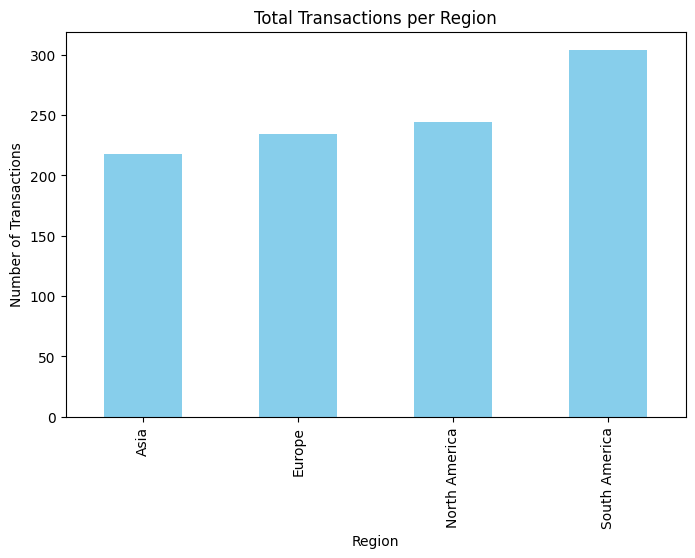

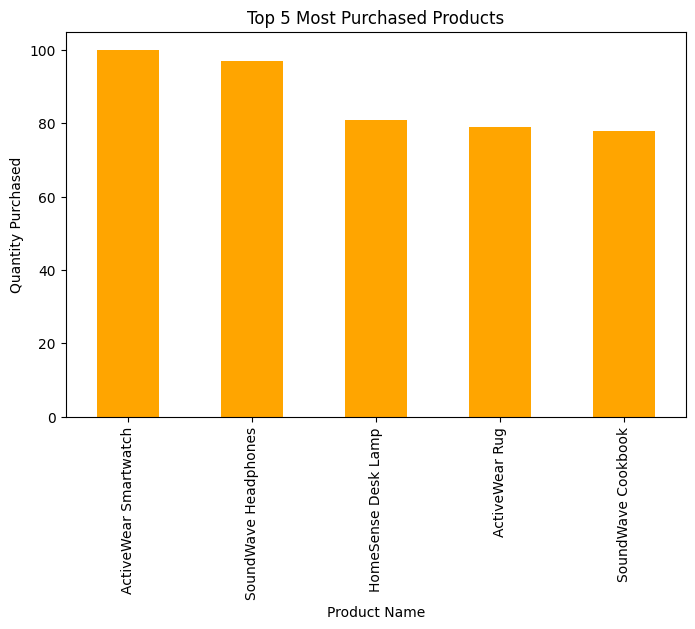

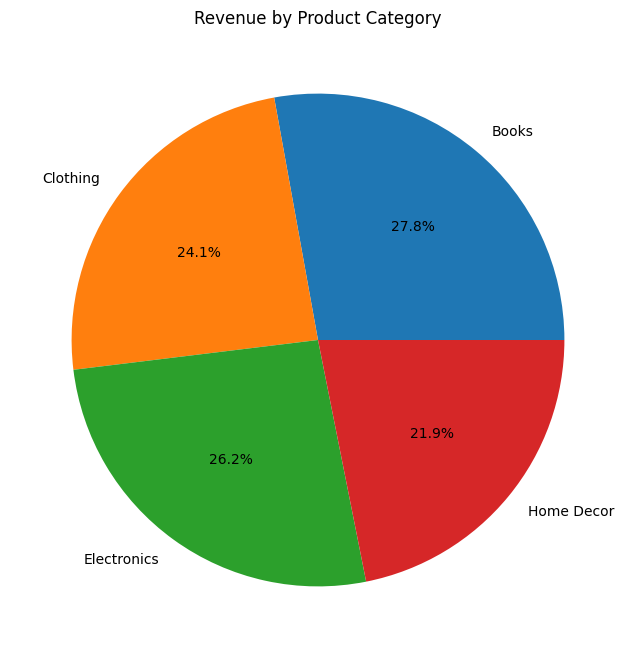

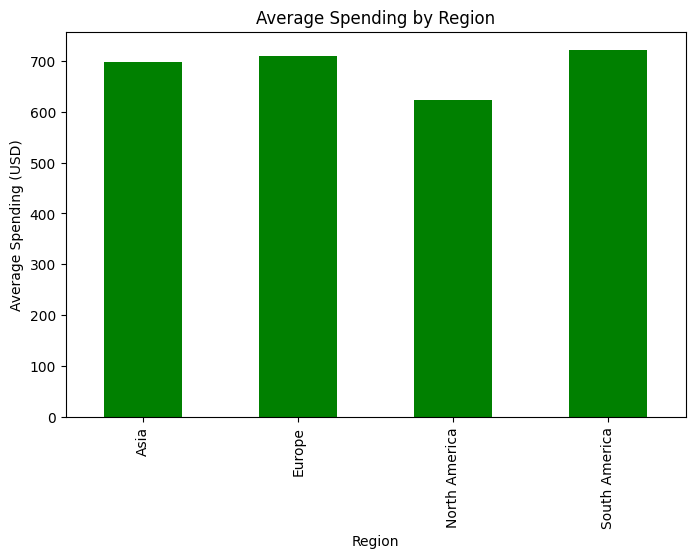

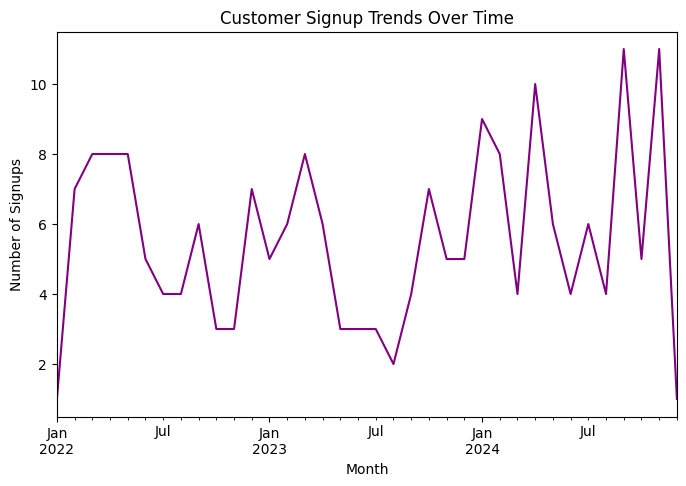

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Check data structure
print(customers.head())
print(products.head())
print(transactions.head())

# Merge datasets for analysis
data = pd.merge(transactions, customers, on="CustomerID", how="inner")
data = pd.merge(data, products, on="ProductID", how="inner")

# Data overview
print(data.info())
print(data.describe())

# EDA visualizations
# 1. Total transactions per region
region_transactions = data.groupby('Region')['TransactionID'].count()
region_transactions.plot(kind='bar', title='Total Transactions per Region', figsize=(8, 5), color='skyblue')
plt.xlabel('Region')
plt.ylabel('Number of Transactions')
plt.show()

# 2. Top 5 most purchased products
top_products = data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(5)
top_products.plot(kind='bar', title='Top 5 Most Purchased Products', figsize=(8, 5), color='orange')
plt.xlabel('Product Name')
plt.ylabel('Quantity Purchased')
plt.show()

# 3. Revenue per category
category_revenue = data.groupby('Category')['TotalValue'].sum()
category_revenue.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), title='Revenue by Product Category')
plt.ylabel('')
plt.show()

# 4. Average spending by region
avg_spending = data.groupby('Region')['TotalValue'].mean()
avg_spending.plot(kind='bar', title='Average Spending by Region', figsize=(8, 5), color='green')
plt.xlabel('Region')
plt.ylabel('Average Spending (USD)')
plt.show()

# 5. Customer signup trends over time
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['SignupMonth'] = customers['SignupDate'].dt.to_period('M')
signup_trends = customers.groupby('SignupMonth')['CustomerID'].count()
signup_trends.plot(kind='line', title='Customer Signup Trends Over Time', figsize=(8, 5), color='purple')
plt.xlabel('Month')
plt.ylabel('Number of Signups')
plt.show()


In [ ]:
#Code for Lookalike Model
# Import libraries
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Aggregate customer data
lookalike_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(lookalike_data[['TotalValue', 'Quantity']])

# Calculate similarity
similarity_matrix = cosine_similarity(scaled_data)

# Create Lookalike CSV
lookalike_results = {}
for idx, customer_id in enumerate(lookalike_data['CustomerID']):
    similarity_scores = list(enumerate(similarity_matrix[idx]))
    # Sort by similarity score
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    # Exclude the customer themselves and get the top 3 similar customers
    top_3 = [(lookalike_data['CustomerID'][i], score) for i, score in similarity_scores[1:4]]
    lookalike_results[customer_id] = top_3

# Save results to Lookalike.csv
import csv
with open('Pranith_Lookalike.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['CustomerID', 'LookalikeCustomers'])
    for customer_id, lookalikes in lookalike_results.items():
        writer.writerow([customer_id, lookalikes])


In [ ]:
#Code for Clustering
# Import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Prepare data for clustering
clustering_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

# Normalize data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data[['TotalValue', 'Quantity', 'Price']])

# Apply K-Means clustering
n_clusters = 4  # You can change this value
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(clustering_data_scaled, clustering_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Visualize Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=clustering_data['TotalValue'], y=clustering_data['Quantity'], hue=clustering_data['Cluster'], palette='tab10')
plt.title('Customer Clusters')
plt.xlabel('Total Value')
plt.ylabel('Quantity')
plt.show()


KeyError: "Column(s) ['Price'] do not exist"